In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import statistics as stat
from math import ceil

In [2]:
img1_bgr = cv2.imread('image1.jpg')
img1 = cv2.cvtColor(img1_bgr, cv2.COLOR_BGR2RGB)
img2_bgr = cv2.imread('image2.jpg')
img2 = cv2.cvtColor(img2_bgr, cv2.COLOR_BGR2RGB)

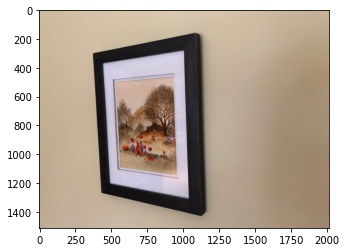

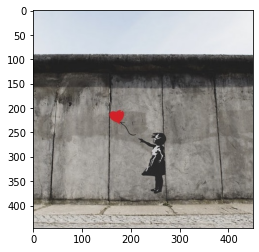

In [3]:
plt.figure()
plt.imshow(img1)
plt.figure()
plt.imshow(img2)

plt.show()

To select the points, I went through the painful and excruciating process of manually selecting points by using opencv's circle function to find the pixel values. The function matplotlib.pyplot.ginput() was not working for me so I had to do it this way. I do not recommend this method... it's not fun. 

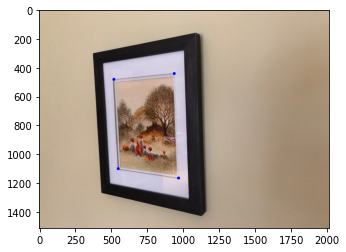

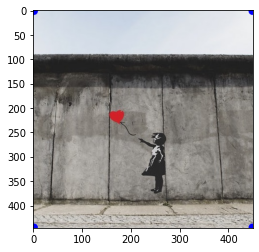

In [4]:
# Radius of circle
radius = 10
  
# Blue color in BGR
color = (255, 0, 0)
  
# Fill circle
thickness = -1

# Selected points for image 1
img1_tl = (520, 480)
img1_tr = (940, 440)
img1_bl = (550, 1100)
img1_br = (970, 1165)

im1 = cv2.circle(img1_bgr, img1_tl, radius, color, thickness)
im1 = cv2.circle(img1_bgr, img1_tr, radius, color, thickness)
im1 = cv2.circle(img1_bgr, img1_bl, radius, color, thickness)
im1 = cv2.circle(img1_bgr, img1_br, radius, color, thickness)
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

img1_points = [img1_tl, img1_tr, img1_bl, img1_br]

# Using the whole image for image 2
img2_tl = (0, 0)
img2_tr = (img2.shape[1], 0)
img2_bl = (0,img2.shape[0])
img2_br = (img2.shape[1], img2.shape[0])

im2 = cv2.circle(img2_bgr, img2_tl, radius, color, thickness)
im2 = cv2.circle(img2_bgr, img2_tr, radius, color, thickness)
im2 = cv2.circle(img2_bgr, img2_bl, radius, color, thickness)
im2 = cv2.circle(img2_bgr, img2_br, radius, color, thickness)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

img2_points = [img2_tl, img2_tr, img2_bl, img2_br]

plt.figure()
plt.imshow(im1)
plt.figure()
plt.imshow(im2)

plt.show()

To replace the picture in image 1 with image2, a homography matrix, H, needs to be computed. The homography matrix is a transformation matrix which maps one image plane to another. This set of equation can be represented by:
$$\textbf{x}_iH = \textbf{x}_i'$$
where $\textbf{x}_i$ is the source image (image 2) and $\textbf{x}_i'$ is the destination image (image 1). In matrix form, these are:

$$\begin{bmatrix} x_1 \\ y_1 \\ 1 \end{bmatrix} \begin{bmatrix} h_{11} & h_{12} & h_{13} \\ h_{21} & h_{22} & h_{23} \\ h_{31} & h_{32} & h_{33} \end{bmatrix} =\begin{bmatrix} x_1' \\ y_1' \\ 1 \end{bmatrix}$$

The cross product of these yields:
$$\textbf{x}_i' \times H\textbf{x}_i = 0$$

We can solve this out and convert this to a inhomogeneous set of linear equations by declaring $h_{33} = 1$. Hence the set of linear equations would be:

$$\begin{bmatrix} x_i & y_i & 1 & 0 & 0 & 0 & -x_ix_i' & -y_ix_i' \\ 0 & 0 & 0 & x_i & y_i & 1 & -x_iy_i' & -y_iy_i'\end{bmatrix} \begin{bmatrix} h_{11} \\ h_{12} \\ h_{13} \\ h_{21} \\ h_{22} \\ h_{23} \\ h_{31} \\ h_{32}\end{bmatrix} = \begin{bmatrix} x_i' \\ y_i'\end{bmatrix}$$ 

where $\textbf{x}_i$ is $2N\times8$ and $\textbf{x}_i'$ is $2N\times1$. $N$ is the number of points. Therefore, 4 points are needed to solve for 8 unknowns. This is a classic $Ax=b$ setup, so we can solve for the homography matrix by doing $A \setminus b = x$

We will now create the A and b matrix and solve for the homography matrix.

In [5]:
def create_a(img1points, img2points): # dest, source
    A = np.zeros((len(img1points)*2,8),dtype=int)
    for i in range(len(img1points)):
        A[2*i] = np.array([img2points[i][0], img2points[i][1], 1, 0, 0, 0, -img2points[i][0]*img1points[i][0], -img2points[i][1]*img1points[i][0]])
        A[2*i + 1] = np.array([0, 0, 0, img2points[i][0], img2points[i][1], 1, -img2points[i][0]*img1points[i][1], -img2points[i][1]*img1points[i][1]])
    return A

In [6]:
def create_b(img1points): # dest
    b = np.zeros((len(img1points)*2,1),dtype=int)
    for i in range(len(img1points)):
        b[2*i]=np.array([img1points[i][0]])
        b[2*i + 1]=np.array([img1points[i][1]])
    return b

In [7]:
def homography(A, b):
    if np.shape(A)[0] == np.shape(A)[1]:
        H = np.linalg.solve(A, b)
    elif np.shape(A)[0] > np.shape(A)[1]:
        H = np.linalg.lstsq(A, b,rcond=None)
    return H

In [8]:
A = create_a(img1_points,img2_points)
b = create_b(img1_points)
print(A)
print(b)

[[      0       0       1       0       0       0       0       0]
 [      0       0       0       0       0       1       0       0]
 [    450       0       1       0       0       0 -423000       0]
 [      0       0       0     450       0       1 -198000       0]
 [      0     446       1       0       0       0       0 -245300]
 [      0       0       0       0     446       1       0 -490600]
 [    450     446       1       0       0       0 -436500 -432620]
 [      0       0       0     450     446       1 -524250 -519590]]
[[ 520]
 [ 480]
 [ 940]
 [ 440]
 [ 550]
 [1100]
 [ 970]
 [1165]]


In [9]:
H = homography(A,b)
H = np.append(H, [1]) # Append matrix with a 1 for h33
H = H.reshape(3,3) 
print(H)

[[ 6.28854735e-01  8.01038705e-02  5.20000000e+02]
 [-2.31410786e-01  1.41581312e+00  4.80000000e+02]
 [-3.23913403e-04  2.33441754e-05  1.00000000e+00]]


In [10]:
# Compare opencv function homography with the solved homography I set up
img1List = np.array(list(img1_points))
img2List = np.array(list(img2_points))

h, status = cv2.findHomography(img2List, img1List)
print(h)

[[ 6.28854735e-01  8.01038705e-02  5.20000000e+02]
 [-2.31410786e-01  1.41581312e+00  4.80000000e+02]
 [-3.23913403e-04  2.33441754e-05  1.00000000e+00]]


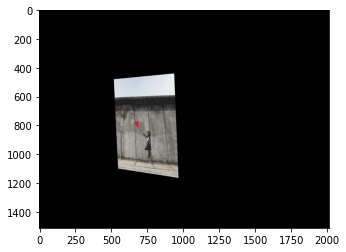

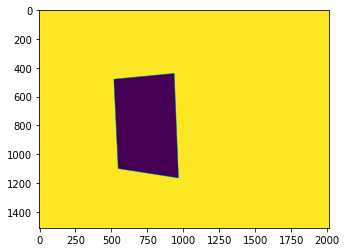

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


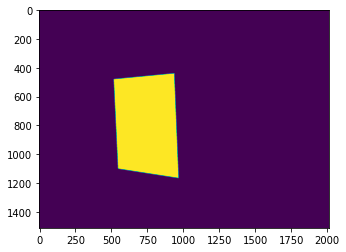

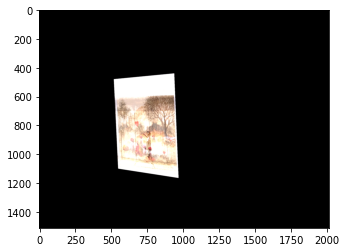

In [16]:
# Warp source image with solved homography
img2Warped = cv2.warpPerspective(img2,h,(img1.shape[1],img1.shape[0]))

plt.figure()
plt.imshow(img2Warped)
plt.show()

# Create mask of warped image
mask = cv2.inRange(img2Warped, 0, 0)
plt.figure()
plt.imshow(mask)
plt.show()
mask = cv2.bitwise_not(mask)
print(mask)
plt.figure()
plt.imshow(mask)
plt.show()

# Get rid of the picture in the frame of the destination image
background = cv2.bitwise_and(img1,img1,mask = mask)

# Add the warped image to this background
overlay = cv2.add(background, img2Warped)
plt.figure()
plt.imshow(overlay)
plt.show()

## 8 Points

Perform the same process as above but with 8 points.

In [75]:
def avg(val1,val2):
    avg = round(stat.mean((val1, val2)))
    return avg

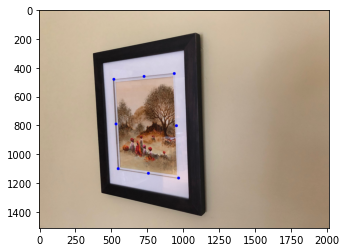

In [76]:
# Create a list of 8 points from the destination image
img1_tl = (520, 480)
img1_tr = (940, 440)
img1_bl = (550, 1100)
img1_br = (970, 1165)

img1_t = (avg(img1_tl[0],img1_tr[0]), avg(img1_tl[1],img1_tr[1]))
img1_r = (avg(img1_tr[0],img1_br[0]), avg(img1_tr[1],img1_br[1]))
img1_l = (avg(img1_tl[0],img1_bl[0]), avg(img1_tl[1],img1_bl[1]))
img1_b = (avg(img1_bl[0],img1_br[0]), avg(img1_bl[1],img1_br[1]))

im1 = cv2.circle(img1_bgr, img1_tl, radius, color, thickness)
im1 = cv2.circle(img1_bgr, img1_tr, radius, color, thickness)
im1 = cv2.circle(img1_bgr, img1_bl, radius, color, thickness)
im1 = cv2.circle(img1_bgr, img1_br, radius, color, thickness)
im1 = cv2.circle(img1_bgr, img1_t, radius, color, thickness)
im1 = cv2.circle(img1_bgr, img1_r, radius, color, thickness)
im1 = cv2.circle(img1_bgr, img1_l, radius, color, thickness)
im1 = cv2.circle(img1_bgr, img1_b, radius, color, thickness)
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

plt.figure()
plt.imshow(im1)
plt.show()

img1_points = [img1_tl, img1_tr, img1_bl, img1_br, img1_t, img1_r, img1_l, img1_b]

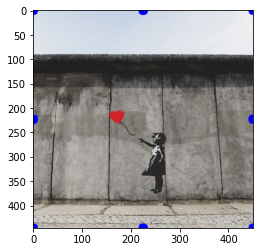

In [77]:
# Using the whole image for image 2
img2_tl = (0, 0)
img2_tr = (img2.shape[1], 0)
img2_bl = (0,img2.shape[0])
img2_br = (img2.shape[1], img2.shape[0])

img2_t = (avg(img2_tl[0],img2_tr[0]), avg(img2_tl[1],img2_tr[1]))
img2_r = (avg(img2_tr[0],img2_br[0]), avg(img2_tr[1],img2_br[1]))
img2_l = (avg(img2_tl[0],img2_bl[0]), avg(img2_tl[1],img2_bl[1]))
img2_b = (avg(img2_bl[0],img2_br[0]), avg(img2_bl[1],img2_br[1]))

im2 = cv2.circle(img2_bgr, img2_tl, radius, color, thickness)
im2 = cv2.circle(img2_bgr, img2_tr, radius, color, thickness)
im2 = cv2.circle(img2_bgr, img2_bl, radius, color, thickness)
im2 = cv2.circle(img2_bgr, img2_br, radius, color, thickness)
im2 = cv2.circle(img2_bgr, img2_t, radius, color, thickness)
im2 = cv2.circle(img2_bgr, img2_r, radius, color, thickness)
im2 = cv2.circle(img2_bgr, img2_l, radius, color, thickness)
im2 = cv2.circle(img2_bgr, img2_b, radius, color, thickness)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

img2_points = [img2_tl, img2_tr, img2_bl, img2_br, img2_t, img2_r, img2_l, img2_b]

plt.figure()
plt.imshow(im2)
plt.show()

In [78]:
# Create A and B matrix
A8 = create_a(img1_points,img2_points)
b8 = create_b(img1_points)
print(A8)
print(b8)

[[      0       0       1       0       0       0       0       0]
 [      0       0       0       0       0       1       0       0]
 [    450       0       1       0       0       0 -423000       0]
 [      0       0       0     450       0       1 -198000       0]
 [      0     446       1       0       0       0       0 -245300]
 [      0       0       0       0     446       1       0 -490600]
 [    450     446       1       0       0       0 -436500 -432620]
 [      0       0       0     450     446       1 -524250 -519590]
 [    225       0       1       0       0       0 -164250       0]
 [      0       0       0     225       0       1 -103500       0]
 [    450     223       1       0       0       0 -429750 -212965]
 [      0       0       0     450     223       1 -360900 -178846]
 [      0     223       1       0       0       0       0 -119305]
 [      0       0       0       0     223       1       0 -176170]
 [    225     446       1       0       0       0 -171000 -338

In [79]:
# Find homography with 8 points and compare to the homography from the opencv function
H8 = homography(A8,b8)
H8 = np.append(H8[0], [1])
H8 = H8.reshape(3,3)
print(H8)

img1List = np.array(list(img1_points))
img2List = np.array(list(img2_points))

h8, status = cv2.findHomography(img2List, img1List)
print(h8)

[[ 6.61389894e-01  6.46428414e-02  5.24225812e+02]
 [-2.01400781e-01  1.40821374e+00  4.76537952e+02]
 [-2.85243678e-04  2.23065297e-06  1.00000000e+00]]
[[ 6.62560388e-01  6.72068282e-02  5.24538313e+02]
 [-1.99376052e-01  1.41459503e+00  4.75979581e+02]
 [-2.82723557e-04  5.93334967e-06  1.00000000e+00]]


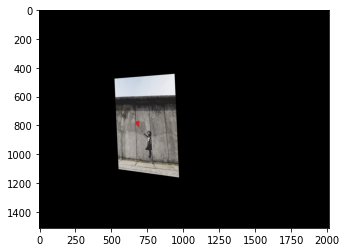

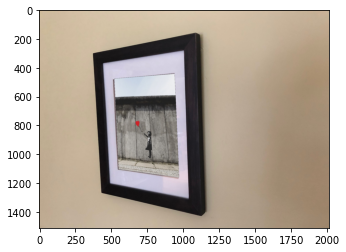

In [80]:
# Warp the image and add it onto the destination image
img2Warped = cv2.warpPerspective(img2,h8,(img1.shape[1],img1.shape[0]))

plt.figure()
plt.imshow(img2Warped)
plt.show()

mask = cv2.inRange(img2Warped, 0, 0)

background = cv2.bitwise_and(img1,img1,mask = mask)

overlay = cv2.add(background, img2Warped)
plt.figure()
plt.imshow(overlay)
plt.show()

In [81]:
print(H8)
print(H)

[[ 6.61389894e-01  6.46428414e-02  5.24225812e+02]
 [-2.01400781e-01  1.40821374e+00  4.76537952e+02]
 [-2.85243678e-04  2.23065297e-06  1.00000000e+00]]
[[ 6.28854735e-01  8.01038705e-02  5.20000000e+02]
 [-2.31410786e-01  1.41581312e+00  4.80000000e+02]
 [-3.23913403e-04  2.33441754e-05  1.00000000e+00]]


## Difference between 8 points and 4 points Homography Matrix
The homography matrix for 8 points and for 4 points has very slight differences. The largest difference is between the first row, second column value where H is 8.01038705e-02 and H8 is 6.46428414e-02. 

## New Image

Perform the same process as above but now with a new image

In [82]:
img3_bgr = cv2.imread('image3.jpg')
img3 = cv2.cvtColor(img3_bgr, cv2.COLOR_BGR2RGB)

In [83]:
# Using the whole image for image 3
img3_tl = (0, 0)
img3_tr = (img3.shape[1], 0)
img3_bl = (0,img3.shape[0])
img3_br = (img3.shape[1], img3.shape[0])

img1_points = [img1_tl, img1_tr, img1_bl, img1_br]
img3_points = [img3_tl, img3_tr, img3_bl, img3_br]

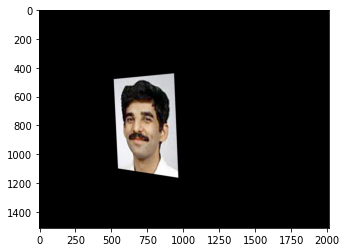

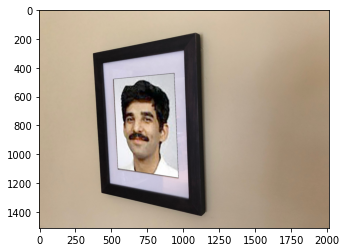

In [84]:
Anew = create_a(img1_points,img3_points)
bnew = create_b(img1_points)
Hnew = homography(Anew,bnew)

img1List = np.array(list(img1_points))
img3List = np.array(list(img3_points))

h_img3, status = cv2.findHomography(img3List, img1List)

img3Warped = cv2.warpPerspective(img3,h_img3,(img1.shape[1],img1.shape[0]))

plt.figure()
plt.imshow(img3Warped)
plt.show()

mask_3 = cv2.inRange(img3Warped, 0, 0)

background_3 = cv2.bitwise_and(img1,img1,mask = mask_3)

overlay_3 = cv2.add(background_3, img3Warped)
plt.figure()
plt.imshow(overlay_3)
plt.show()

## Mosaic

We will now create a mosaic by finding the homography between each image and stitching the images to create a mosaic

In [85]:
mos1_bgr = cv2.imread('mos1.jpg')
mos1_bgr = cv2.resize(mos1_bgr, (1280,1024))
mos1 = cv2.cvtColor(mos1_bgr, cv2.COLOR_BGR2RGB)

mos2_bgr = cv2.imread('mos2.jpg')
mos2_bgr = cv2.resize(mos2_bgr, (1280,1024))
mos2 = cv2.cvtColor(mos2_bgr, cv2.COLOR_BGR2RGB)

mos3_bgr = cv2.imread('mos3.jpg')
mos3_bgr = cv2.resize(mos3_bgr, (1280,1024))
mos3 = cv2.cvtColor(mos3_bgr, cv2.COLOR_BGR2RGB)

mos4_bgr = cv2.imread('mos4.jpg')
mos4_bgr = cv2.resize(mos4_bgr, (1280,1024))
mos4 = cv2.cvtColor(mos4_bgr, cv2.COLOR_BGR2RGB)

mos5_bgr = cv2.imread('mos5.jpg')
mos5_bgr = cv2.resize(mos5_bgr, (1280,1024))
mos5 = cv2.cvtColor(mos5_bgr, cv2.COLOR_BGR2RGB)

mos = [mos1, mos2, mos3, mos4, mos5]
mos_bgr = [mos1_bgr, mos2_bgr, mos3_bgr, mos4_bgr, mos5_bgr]

Each of these points were handpicked from images using the Select_Points.ipynb

In [86]:
mos1_2_pt1 = (379, 751)
mos1_2_pt2 = (1025, 826)
mos1_2_pt3 = (451, 394)
mos1_2_pt4 = (795, 397)

mos1_2_points = [mos1_2_pt1, mos1_2_pt2, mos1_2_pt3, mos1_2_pt4]

mos2_1_pt1 = (11, 771)
mos2_1_pt2 = (678, 815)
mos2_1_pt3 = (105, 383)
mos2_1_pt4 = (468, 394)

mos2_1_points = [mos2_1_pt1, mos2_1_pt2, mos2_1_pt3, mos2_1_pt4]

mos2_3_pt1 = (675, 818)
mos2_3_pt2 = (1108, 837)
mos2_3_pt3 = (1047, 441)
mos2_3_pt4 = (470, 391)

mos2_3_points = [mos2_3_pt1, mos2_3_pt2, mos2_3_pt3, mos2_3_pt4]

mos3_2_pt1 = (393, 815)
mos3_2_pt2 = (811, 815)
mos3_2_pt3 = (775, 441)
mos3_2_pt4 = (185, 375)

mos3_2_points = [mos3_2_pt1, mos3_2_pt2, mos3_2_pt3, mos3_2_pt4]

mos3_4_pt1 = (811, 815)
mos3_4_pt2 = (772, 447)
mos3_4_pt3 = (1138, 358)
mos3_4_pt4 = (1185, 774)

mos3_4_points = [mos3_4_pt1, mos3_4_pt2, mos3_4_pt3, mos3_4_pt4]

mos4_3_pt1 = (446, 812)
mos4_3_pt2 = (437, 444)
mos4_3_pt3 = (784, 375)
mos4_3_pt4 = (797, 754)

mos4_3_points = [mos4_3_pt1, mos4_3_pt2, mos4_3_pt3, mos4_3_pt4]

mos4_5_pt1 = (443, 812)
mos4_5_pt2 = (797, 754)
mos4_5_pt3 = (1127, 560)
mos4_5_pt4 = (781, 372)

mos4_5_points = [mos4_5_pt1, mos4_5_pt2, mos4_5_pt3, mos4_5_pt4]

mos5_4_pt1 = (52, 848)
mos5_4_pt2 = (446, 768)
mos5_4_pt3 = (775, 563)
mos5_4_pt4 = (457, 380)

mos5_4_points = [mos5_4_pt1, mos5_4_pt2, mos5_4_pt3, mos5_4_pt4]

In [87]:
def warp2Images(img1, img2, H): # Credit here: https://datahacker.rs/005-how-to-create-a-panorama-image-using-opencv-with-python/ with some modifications

  rows1, cols1 = img1.shape[:2]
  rows2, cols2 = img2.shape[:2]

  list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
  temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)

  # When we have established a homography we need to warp perspective
  # Change field of view
  list_of_points_2 = cv2.perspectiveTransform(temp_points, H)

  list_of_points = np.concatenate((list_of_points_1,list_of_points_2), axis=0)
  print(list_of_points)

  [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
  [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)
  print(x_min)
  print(y_min)
  H_translation = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]])

  output_img = cv2.warpPerspective(img2, H_translation.dot(H), (x_max-x_min, y_max-y_min))
  output_img[-y_min:rows1-y_min, -x_min:cols1-x_min] = img1

  return output_img

In [88]:
def imgWarp(src,dest,H): # I took this from Jordan Gittleman and added the y axis to the calculation

    h1,w1 = src.shape[:2]
    h2,w2 = dest.shape[:2]
    pts = np.float32([[0,0], [0, h1],[w1, h1], [w1, 0]]) #create an array of just the corners in order top left, top right, bottom left, bottom right

    transPts=[]
    for pt in pts:
        transPts.append(np.matmul(H,np.array([pt[0],pt[1],1]))) # matmul the corners by the homography

    # Find minimum and maximum values for x and y of corners. This section was inspired by Xavier Hubbard
    x_min = min(pt[0]/pt[2] for pt in transPts)
    x_max = max(pt[0]/pt[2] for pt in transPts)
    y_min = min(pt[1]/pt[2] for pt in transPts)
    y_max = max(pt[1]/pt[2] for pt in transPts)

    if x_min < 0:
        x_shift = abs(x_min)
    elif x_min > 0:
        x_shift = 0

    if y_min <0:
        y_shift = abs(y_min)
    elif y_min > 0:
        y_shift = 0

    dim = (int(x_max+x_shift+w2),int(y_max+y_shift))

    transH = np.array([[1,0,np.ceil(x_shift)],[0,1,np.ceil(y_shift)],[0,0,1]]) # translation homography

    #now lets combine it with our original H!

    H_total=np.matmul(transH,H)

    # Warp image and keypoints
    out_img = cv2.warpPerspective(src,H_total,dim)
    out_dest_img = cv2.warpPerspective(dest,transH,dim)
    out_mask=np.any(out_img,2)
    out_mask=np.repeat(out_mask[:,:,np.newaxis], 3, axis=2)
    out_dest_mask=np.any(out_dest_img,2)
    out_dest_mask=np.repeat(out_dest_mask[:,:,np.newaxis], 3, axis=2)
    mask_result=np.bitwise_and(out_mask,out_dest_mask).astype("uint8")
    
    
    result = cv2.addWeighted(out_img, 0.5, out_dest_img, 0.5, 0) # Create blend

    mask_result=(cv2.cvtColor(mask_result, cv2.COLOR_BGR2GRAY))

    output=cv2.bitwise_and(result,result,mask=mask_result)
    result=cv2.subtract(result,output)
    result=cv2.add(result,result)
    output2 = cv2.add(output, result)

    # cut out black space to the right of the image    
    h,w = output2.shape[:2]
    bounds=np.any(output2,2)
    edge=0
    for x in range(w-1,0,-1):
        if bounds[int(h/2), x] != 0:
            edge = x
            break
    output_im=output2[:,:edge,:]
    
    return (output_im, H_total, transH)

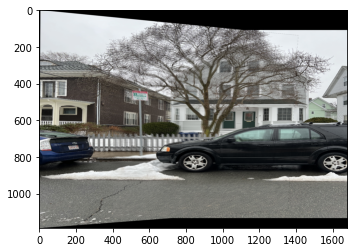

In [89]:
A2_3 = create_a(mos3_2_points, mos2_3_points)
b2_3 = create_b(mos3_2_points)
H2_3 = homography(A2_3,b2_3)
H2_3 = np.append(H2_3, [1])
H2_3 = H2_3.reshape(3,3)

output, H23, trans_h23 = imgWarp(mos2,mos3, H2_3) # good

plt.figure()
plt.imshow(output)
plt.show()

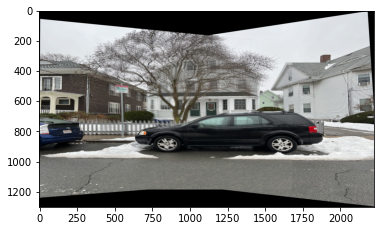

In [90]:
A4_3 = create_a(mos3_4_points, mos4_3_points)
b4_3 = create_b(mos3_4_points)
H4_3 = homography(A4_3,b4_3)
H4_3 = np.append(H4_3, [1])
H4_3 = H4_3.reshape(3,3)

output1, H234, trans_h234 = imgWarp(mos4, output, np.matmul(trans_h23, H4_3)) # good

plt.figure()
plt.imshow(output1)
plt.show()

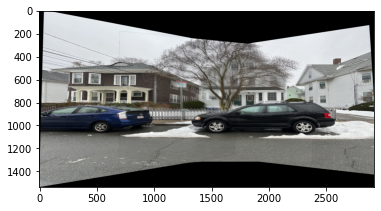

In [91]:
A2_1 = create_a(mos2_1_points, mos1_2_points)
b2_1 = create_b(mos2_1_points)
H1_2 = homography(A2_1,b2_1)
H1_2 = np.append(H1_2, [1])
H1_2 = H1_2.reshape(3,3)

output2, H1234, trans_h1234 = imgWarp(mos1, output1, np.matmul(trans_h234, np.matmul(H23, H1_2))) # good

plt.figure()
plt.imshow(output2)
plt.show()

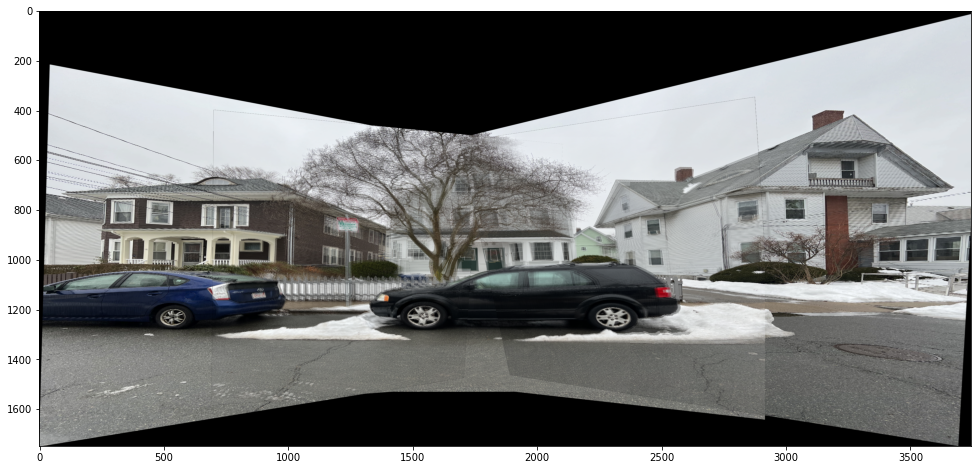

In [92]:
A5_4 = create_a(mos4_5_points, mos5_4_points)
b5_4 = create_b(mos4_5_points)
H5_4 = homography(A5_4,b5_4)
H5_4 = np.append(H5_4, [1])
H5_4 = H5_4.reshape(3,3)

output3, H12345, trans_h12345 = imgWarp(mos5, output2, np.matmul(trans_h1234, np.matmul(H234, H5_4)))

plt.figure(figsize=(20,8))
plt.imshow(output3)
plt.show()

## Discussion

The mosaic came out very well but is slightly blurry in the tree. The points I selected were not located in the tree at all. However, the image stiched well in that area despite looking a bit blurry, when the original images were not blurry. Perhaps if points were selected in the tree, it may have turned out a bit better. In any case, the result looks fine.